In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Load datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
test_labels = pd.read_csv('test_labels.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Check the structure of the training data
print(train_data.head())



                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [3]:
# Preprocessing for Naive Bayes
train_data['comment_text'] = train_data['comment_text'].fillna('')
test_data['comment_text'] = test_data['comment_text'].fillna('')

# Labels for toxic comments
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
X_train = train_data['comment_text']
y_train = train_data[labels]

# Split data for validation
X_train_nb, X_val_nb, y_train_nb, y_val_nb = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Vectorization for Naive Bayes
vectorizer = CountVectorizer(max_features=10000, stop_words='english')
X_train_nb_vect = vectorizer.fit_transform(X_train_nb)
X_val_nb_vect = vectorizer.transform(X_val_nb)


In [4]:
# Train Naive Bayes for each label
nb_models = {}
for label in labels:
    nb_model = MultinomialNB()
    nb_model.fit(X_train_nb_vect, y_train_nb[label])
    nb_models[label] = nb_model

# Evaluate Naive Bayes
for label in labels:
    y_pred = nb_models[label].predict(X_val_nb_vect)
    print(f"Results for {label}:")
    print(classification_report(y_val_nb[label], y_pred))
    print("Accuracy:", accuracy_score(y_val_nb[label], y_pred))


Results for toxic:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     28859
           1       0.75      0.70      0.72      3056

    accuracy                           0.95     31915
   macro avg       0.86      0.84      0.85     31915
weighted avg       0.95      0.95      0.95     31915

Accuracy: 0.9483001723327589
Results for severe_toxic:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     31594
           1       0.35      0.69      0.47       321

    accuracy                           0.98     31915
   macro avg       0.67      0.84      0.73     31915
weighted avg       0.99      0.98      0.99     31915

Accuracy: 0.9841140529531568
Results for obscene:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     30200
           1       0.70      0.76      0.73      1715

    accuracy                           0.97     31915
   m

In [5]:
# Tokenization using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training data
X_train_bert = tokenizer(
    list(X_train), 
    max_length=128, 
    padding=True, 
    truncation=True, 
    return_tensors='tf'
)

# Create BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Define a BERT-based model for classification
input_ids = tf.keras.Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(128,), dtype=tf.int32, name="attention_mask")

bert_output = bert_model(input_ids, attention_mask=attention_mask)
cls_token = bert_output.last_hidden_state[:, 0, :]  # CLS token

output = tf.keras.layers.Dense(len(labels), activation='sigmoid')(cls_token)

bert_classifier = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model
bert_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Prepare training data
train_inputs = {
    'input_ids': X_train_bert['input_ids'],
    'attention_mask': X_train_bert['attention_mask']
}

# Train the model
bert_classifier.fit(train_inputs, y_train, epochs=3, batch_size=16, validation_split=0.2)


c:\Users\vivek\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3


   5/7979 [..............................] - ETA: 132:07:35 - loss: 0.5266 - accuracy: 0.0750   

KeyboardInterrupt: 

In [ ]:
# Tokenize validation data
X_val_bert = tokenizer(
    list(X_val_nb), 
    max_length=128, 
    padding=True, 
    truncation=True, 
    return_tensors='tf'
)

val_inputs = {
    'input_ids': X_val_bert['input_ids'],
    'attention_mask': X_val_bert['attention_mask']
}

# Predict and evaluate BERT
bert_preds = bert_classifier.predict(val_inputs)
bert_preds = (bert_preds > 0.5).astype(int)

for i, label in enumerate(labels):
    print(f"Results for {label} with BERT:")
    print(classification_report(y_val_nb[label], bert_preds[:, i]))
    print("Accuracy:", accuracy_score(y_val_nb[label], bert_preds[:, i]))


In [6]:
# Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, label):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Confusion Matrix for toxic (Naive Bayes):


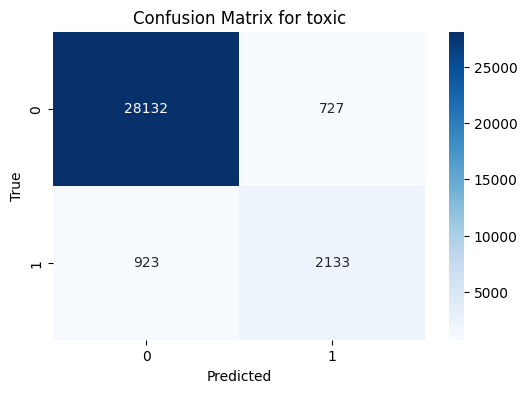

Confusion Matrix for severe_toxic (Naive Bayes):


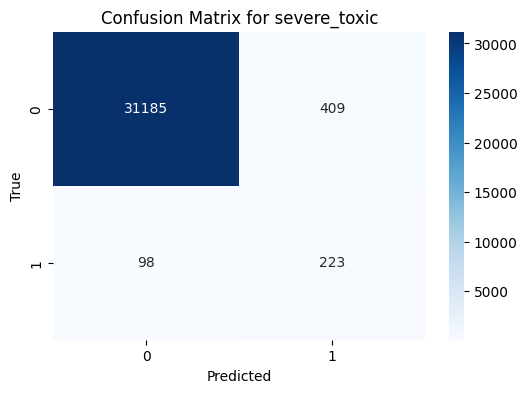

Confusion Matrix for obscene (Naive Bayes):


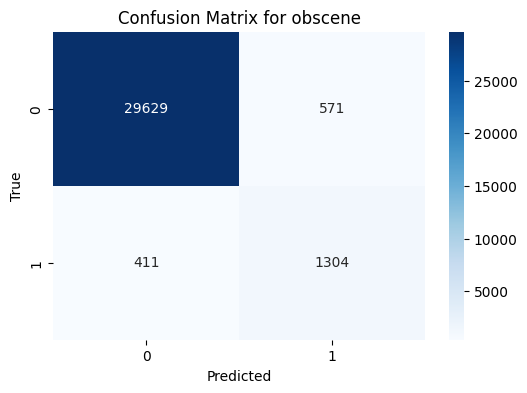

Confusion Matrix for threat (Naive Bayes):


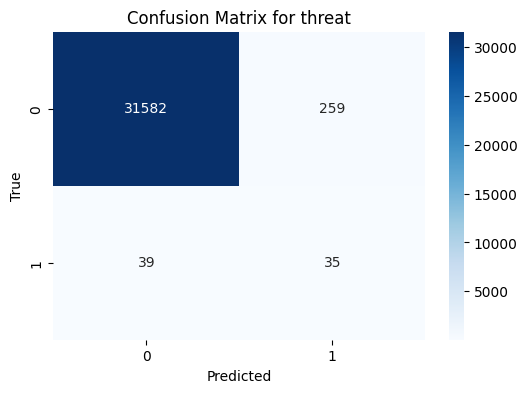

Confusion Matrix for insult (Naive Bayes):


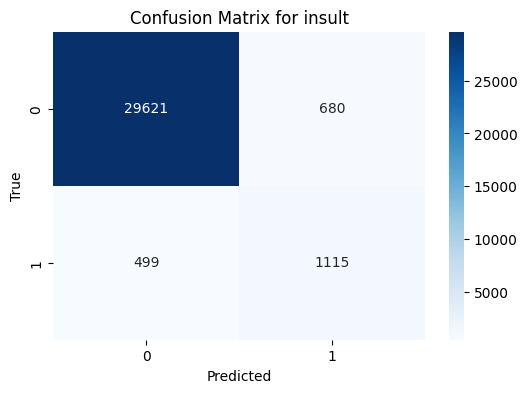

Confusion Matrix for identity_hate (Naive Bayes):


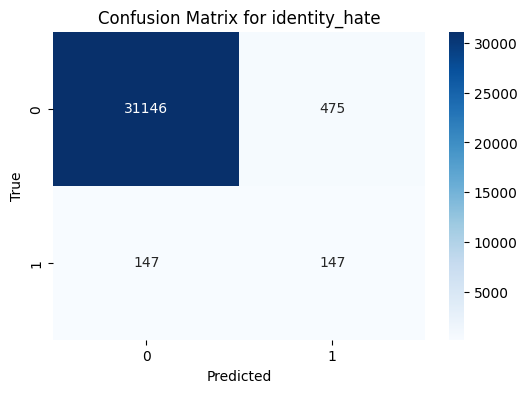

In [7]:
# Plot confusion matrices for Naive Bayes model
for label in labels:
    y_true = y_val_nb[label]
    y_pred = nb_models[label].predict(X_val_nb_vect)
    print(f"Confusion Matrix for {label} (Naive Bayes):")
    plot_confusion_matrix(y_true, y_pred, label)


In [ ]:
# Plot confusion matrices for BERT model
for i, label in enumerate(labels):
    y_true = y_val_nb[label]
    y_pred = bert_preds[:, i]
    print(f"Confusion Matrix for {label} (BERT):")
    plot_confusion_matrix(y_true, y_pred, label)

# Function to plot ROC Curve
def plot_roc_curve(y_true, y_pred, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve for {label}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC Curves for BERT model
for i, label in enumerate(labels):
    y_true = y_val_nb[label]
    y_pred = bert_preds[:, i]
    print(f"ROC Curve for {label} (BERT):")
    plot_roc_curve(y_true, y_pred, label)


In [ ]:
# Calculate accuracies for Naive Bayes and BERT
nb_accuracies = [accuracy_score(y_val_nb[label], nb_models[label].predict(X_val_nb_vect)) for label in labels]
bert_accuracies = [accuracy_score(y_val_nb[label], bert_preds[:, i]) for i, label in enumerate(labels)]

# Plot the accuracies
plt.figure(figsize=(10, 6))
x = np.arange(len(labels))
plt.bar(x - 0.2, nb_accuracies, 0.4, label='Naive Bayes')
plt.bar(x + 0.2, bert_accuracies, 0.4, label='BERT')
plt.xticks(x, labels)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Naive Bayes vs BERT')
plt.legend()
plt.show()
